# Text -> binary -> codeword -> binary -> text

In [1]:
import txt_binary as tb
import BinaryToCodeword as b2c
import CodewordToBinary as c2b

In [2]:
#####################
###### TO KEEP ######
#####################

txt = "Les#é!^ ?''& %* ç a"

def textToCodewords(txt):
    bits = tb.text_to_bits(txt)
    codeword = b2c.f(bits)
    return codeword


def codewordToText(codeword):
    bits2 = c2b.f(codeword)
    res = tb.text_from_bits(bits2)
    return res

codeword = textToCodewords(txt)
res = codewordToText(codeword)

print(res)

#####################
###### TO KEEP ######
#####################

Les#é!^ ?''& %* ç a


---
# Clap definition

In [3]:
clap = 5*"#"

---
# Mathematical part to study $\Psi$(t)

In [4]:
import numpy as np
#np.seterr(divide='ignore', invalid='ignore')
from matplotlib import pyplot as plt
%matplotlib inline

To observe what we have for our $\psi$ function.

In [5]:
beta = 1/2.0
#T_psi : good values begin at 1/400 and its better if we 
T_psi = 1/600.0 # we want it small (try to play with and see) but be careful aliasing when we add 4 modulated version of it
print("The frequency-band will have a width of:",1/T_psi,"Hz until 1/2T (see p. 171)")

def psi(t):
    c = 1.0 - np.square(4.0 * beta * t / T_psi)
    
    temp_error = np.geterr()
    np.seterr(divide='ignore', invalid='ignore')
    res = np.where(np.abs(c) <= 1E-2,
                   (beta / (np.pi * np.sqrt(2 * T_psi)))
                   * ((np.pi + 2) * np.sin(np.pi / (4 * beta))
                      +(np.pi - 2) * np.cos(np.pi / (4 * beta))),
                   
                   (4.0 * beta)/(np.pi * np.sqrt(T_psi))
                   * (np.cos((1.0 + beta) * np.pi * t / T_psi)
                      + ((1.0 - beta) * np.pi) / (4.0 * beta) * np.sinc((1.0 - beta) * t / T_psi))
                   / c
                   )
    np.seterr(divide='warn', invalid='warn')
    
    return res

The frequency-band will have a width of: 600.0 Hz until 1/2T (see p. 171)


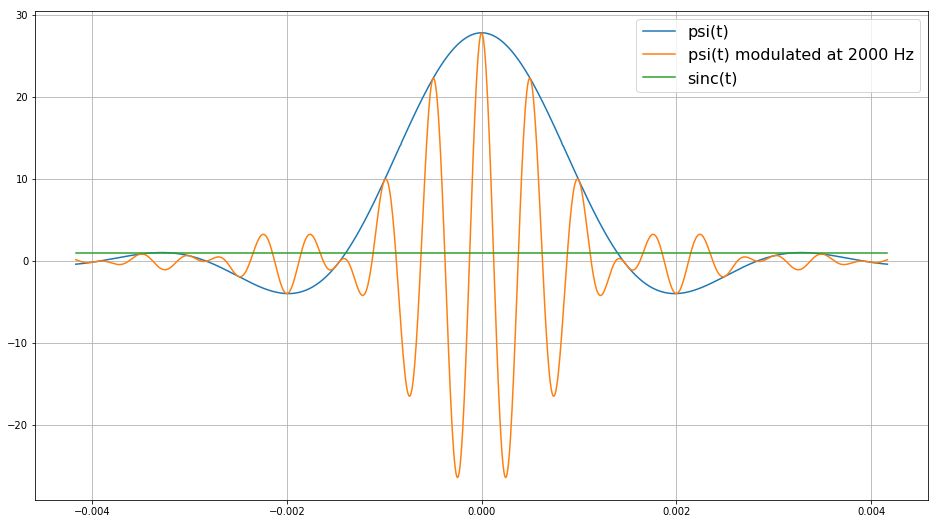

In [6]:
t = np.linspace(start=-5*T_psi/(4*beta), stop=5*T_psi/(4*beta), num = 1000)
freq = 2000

plt.figure(figsize=(16,9))
plt.plot(t, psi(t), t, psi(t)*np.cos(2*np.pi*freq*t), t, np.sinc(t))
plt.legend(["psi(t)", "psi(t) modulated at " + str(freq) + " Hz", "sinc(t)"], fontsize=16)
plt.grid()
plt.show()

If *T_psi* really small, then the blue curve and the yellow one are superposed.

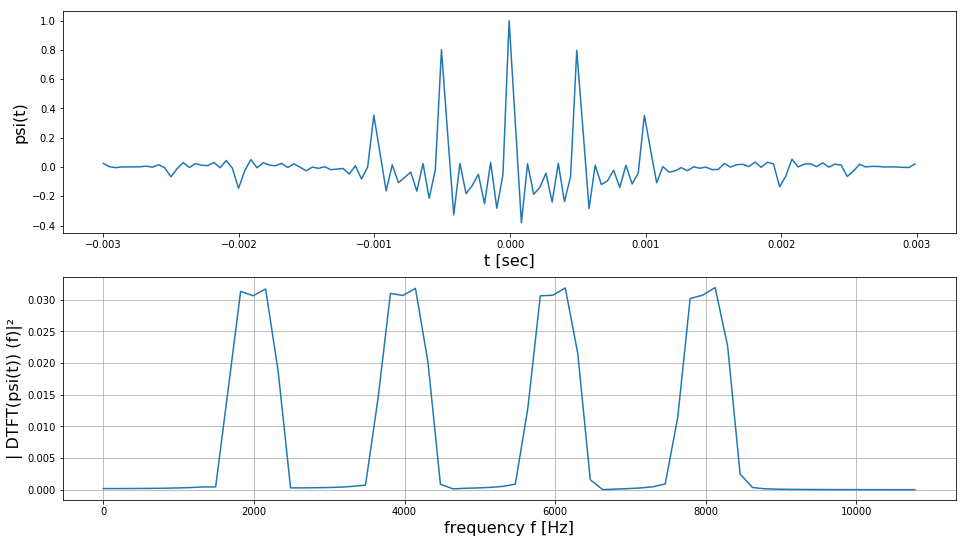

In [7]:
#############################################
###### https://plot.ly/matplotlib/fft/ ######
#############################################

#Fs = 8.0 * ff + (1.55/T_psi)  # sampling rate /!\ Choose a factor which respect the sampling theorem (>=2*4 + a little bit to avoid aliasing in freq domain)
#oversampling_factor = 1 #Don't oversample please =)

#init some global variables
ff = 2000 # frequency of the signal in Hz
Fs = 22050 #* oversampling_factor #Don't change, it 's fixed in the pdf
Ts = 1.0/Fs # sampling interval
time_interval = 0.003
t = np.arange(-time_interval, time_interval, Ts) # time vector

#amplitude = 1
y_base = psi(t) #* amplitude

# Modulate a given signal and resize it to [-1,1]
def modulate_and_resize(y_base):
    y = y_base * np.cos(2*np.pi*ff*t) + y_base * np.cos(2*2*np.pi*ff*t) + y_base * np.cos(3*2*np.pi*ff*t) + y_base * np.cos(4*2*np.pi*ff*t)
    ymax = np.max(np.abs(y))
    y /= ymax
    return y
    
# Add gaussian noise to a given signal
def addNoise(y):
    n = len(y) # length of the signal
    print("number of sample needed:",n)
    y = y + np.random.normal(0, 0.05, n)
    return y

def getSignal():
    y_base = psi(t)
    y = modulate_and_resize(y_base)
    return y
    #return addNoise(y)

y_to_send = getSignal()

################
##### PLOT #####
################
n = len(y_to_send)
k = np.arange(n)
T = n/Fs
frq = k/T # two sides frequency range
frq = frq[range(n // 2)] # one side frequency range (7 = 3*2+1 ==> 7//2 = 6//2 = 3)

Y = np.fft.fft(y_to_send)/n # fft computing and normalization
Y = Y[range(n // 2)]

plt.figure(figsize=(16,9))
plt.subplot(211)
plt.plot(t,y_to_send)
plt.xlabel("t [sec]",fontsize=16)
plt.ylabel("psi(t)",fontsize=16)
plt.subplot(212)
plt.plot(frq, np.abs(Y))
plt.xlabel("frequency f [Hz]",fontsize=16)
plt.ylabel("| DTFT(psi(t)) (f)|²",fontsize=16)
plt.grid()
plt.show()

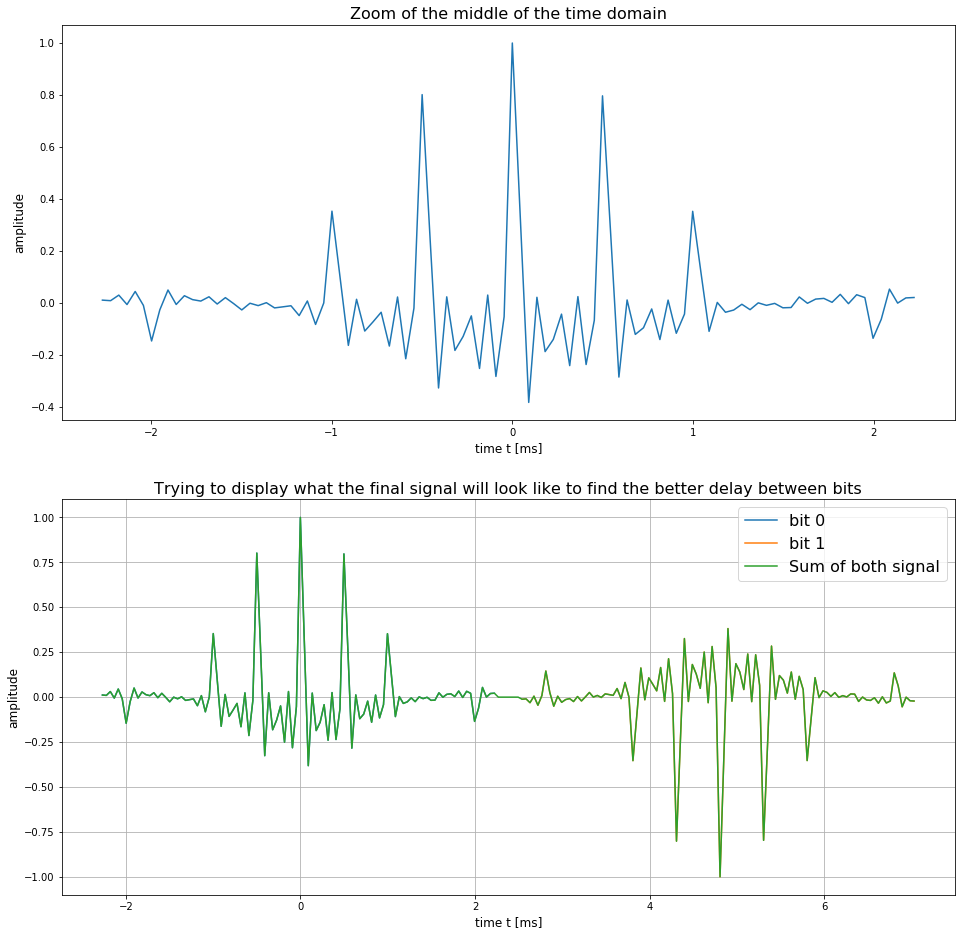

In [8]:
sample_interval = int(min(n/2, 50))
test = y_to_send[len(y_to_send)//2-sample_interval:len(y_to_send)//2+sample_interval]

#delay = int(min(n/2, 57)) # number of sample that we wait before sending the second bit
delay = int(min(n/1.25, n))

bit0 = 1
bit1 = -1

sum = [0 for i in range(len(test) + delay)]
for i in range(len(sum)):
    j = i-delay
    if (i < len(test)):
        sum[i] += bit0 * test[i]
    if (j >= 0):
        sum[i] += bit1 * test[j]

plt.figure(figsize=(16,16))
plt.grid(b=True)
plt.subplot(211)
plt.plot([(i-sample_interval)*1E3*Ts for i in range(len(test))], bit0 * test)
plt.title("Zoom of the middle of the time domain",fontsize=16)
plt.xlabel("time t [ms]", fontsize=12)
plt.ylabel("amplitude",fontsize=12)
plt.subplot(212)
plt.plot([(i-sample_interval)*1E3*Ts for i in range(len(test))], bit0 * test,
         [(i+delay-sample_interval)*1E3*Ts for i in range(len(test))], bit1 * test,
         [(i-sample_interval)*1E3*Ts for i in range(len(sum))], sum)
plt.title("Trying to display what the final signal will look like to find the better delay between bits",fontsize=16)
plt.xlabel("time t [ms]", fontsize=12)
plt.ylabel("amplitude",fontsize=12)
plt.legend(["bit 0", "bit 1", "Sum of both signal"], fontsize=16)
plt.grid()
plt.show()

In [9]:
print("Estimation of how many addition are needed to compute the signal that will be send to the server [#additions]:", n*160)
amplitude = 1
print("\nUSING AMPLITUDE THRESHOLD:")
est_time_shift = 2*(time_interval-np.argwhere(np.abs(y_to_send) >= 3.0 * 1E-1*amplitude)[0,0]*Ts) # Estimated time shift between 2 bits
print(est_time_shift/2.*1E3)
print("Estimation of the timeshift needed between two bits [ms]:",est_time_shift*1E3)
print("Estimation of how long the *.wav that we will send to the server will be [s]:",160*8*est_time_shift)

print("\nUSING GRAPHICAL APPROXIMATION:")
est_time_shift = delay*Ts
print(est_time_shift/2.*1E3)
print("Estimation of the timeshift needed between two bits [ms]:",est_time_shift*1E3)
print("Estimation of how long the *.wav that we will send to the server will be [s]:",160*8*est_time_shift)

###################################
print("\nNot interesting tests:")

#transform time to a number of sample. Used to find a delay approximation by the graphical way
time_to_transform = 1.3
print(2*(time_to_transform/Ts*1E-3))

Estimation of how many addition are needed to compute the signal that will be send to the server [#additions]: 21280

USING AMPLITUDE THRESHOLD:
1.00453514739229
Estimation of the timeshift needed between two bits [ms]: 2.00907029478458
Estimation of how long the *.wav that we will send to the server will be [s]: 2.571609977324263

USING GRAPHICAL APPROXIMATION:
2.4036281179138324
Estimation of the timeshift needed between two bits [ms]: 4.807256235827665
Estimation of how long the *.wav that we will send to the server will be [s]: 6.153287981859411

Not interesting tests:
57.33


---
# Encoding

In [10]:
def encode(list_codewords, signal):
    signal_length = len(signal)
    res = np.zeros(len(list_codewords) * signal_length)
    
    for i in range(len(list_codewords)):
        for j in range(signal_length):
            res[i * signal_length + j] = list_codewords[i] * y_to_send[j]
    
    return res

signal start at 500


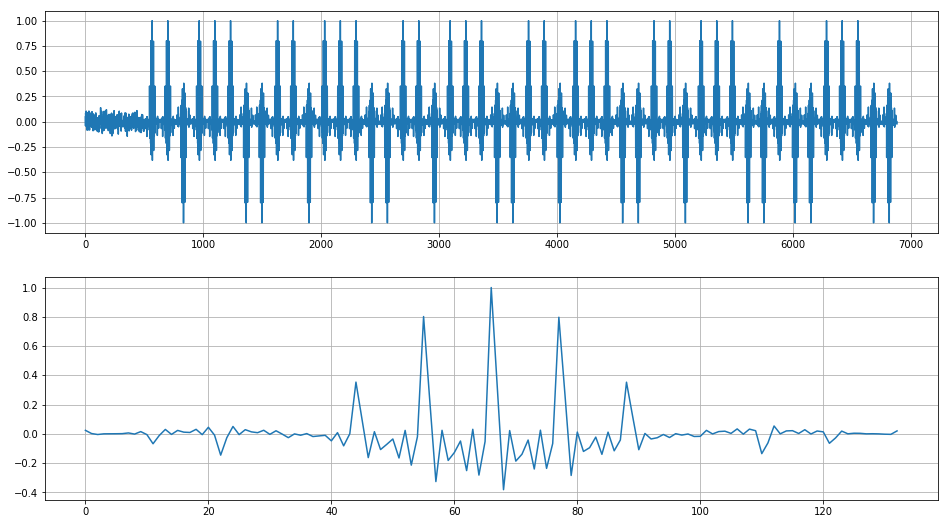

In [19]:
code_to_send = b2c.f(tb.text_to_bits(clap + 'c'))

signal_test = encode(code_to_send, y_to_send)
signal_test_test = [] #with added noise at the beginning -> use clap
addPhase = 500
for i in range(len(signal_test) + addPhase):
    if(i == addPhase):
        print("signal start at " + str(i))
    if(i<addPhase):
        signal_test_test.append(np.random.normal(0,0.05, 1))
    else:
        signal_test_test.append(signal_test[i-addPhase])

plt.figure(figsize=(16,9))
plt.subplot(211)
plt.plot(signal_test_test)
plt.grid()
plt.subplot(212)
plt.plot(y_to_send)
plt.grid()
plt.show()

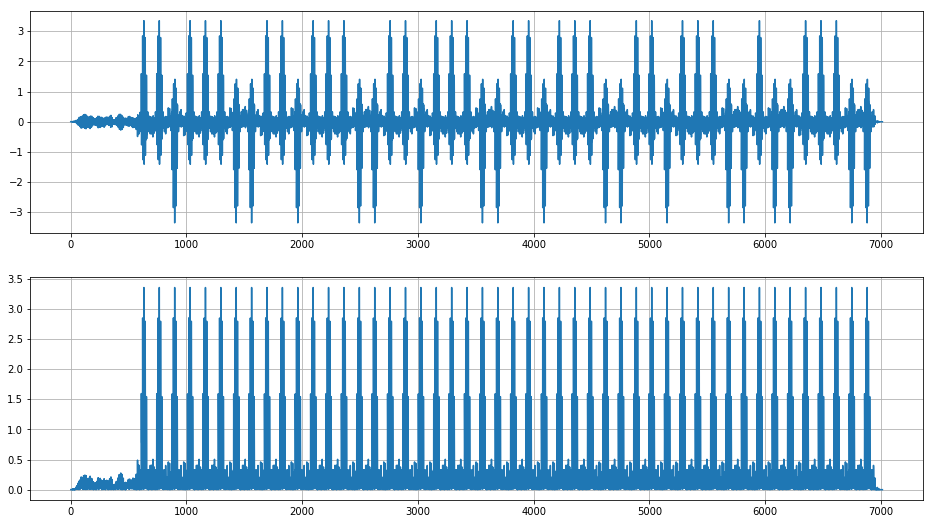

signal start at index : 
500


In [21]:
def toAbs(tab):
    for i in range(len(tab)):
        tab[i] = np.abs(tab[i])

def findOffset2(signal_received, signal_desired, signal_desired_length):
    start = 0
    while(signal_received[start] < 0.5):
        start += 1
    start -= 55
    print(signal_desired_length)
    print(start)
    print(len(signal_received) - signal_desired_length - start)
    a = []
    for i in range(len(signal_received) - signal_desired_length - start):
        temp = 0
        for j in range(signal_desired_length):
            temp += signal_received[i+j+start] * signal_desired[j]
        a.append(temp)
    
    print("max at :")
    print(np.argmax(a))
    return np.argmax(a) + start
    
def findOffset(signal_received, signal_desired, signal_desired_length):
    conv = np.convolve(signal_received, signal_desired)
        
    plt.figure(figsize=(16,9))
    plt.subplot(211)
    plt.plot(conv)
    plt.grid()
    plt.subplot(212)
    
    toAbs(conv)
    
    plt.plot(conv) #np.fft.fft(conv))
    plt.grid()
    plt.show()

    return np.argmax(conv) - signal_desired_length + 1

clap_codeword = textToCodewords("b")
clap_encoded = encode(clap_codeword, y_to_send)
offset = findOffset(signal_test_test, y_to_send, len(y_to_send))
print("signal start at index : ")
print(offset)

---
# TODOs

* Compute signal to noise ratio to estimate mathematically the amplification needed to obtain a good SNR
    * Oversampling ?  ==> no reduce the number of samples taken (reduce variable time_interval)
* Demodulation
    * Hilbert demodulation ?
* LES 40000 bits en plus c'est chiant ==> mettre au début de la string qu'on envoie
    * add for example 50 times "$\$$" at the beginning and at the end
* Décodage en 2 fois (CLAP)
    * maximiser la fonction d'auto-corrélation ==> séquence pseudo-aléatoire

---
# Not important tests

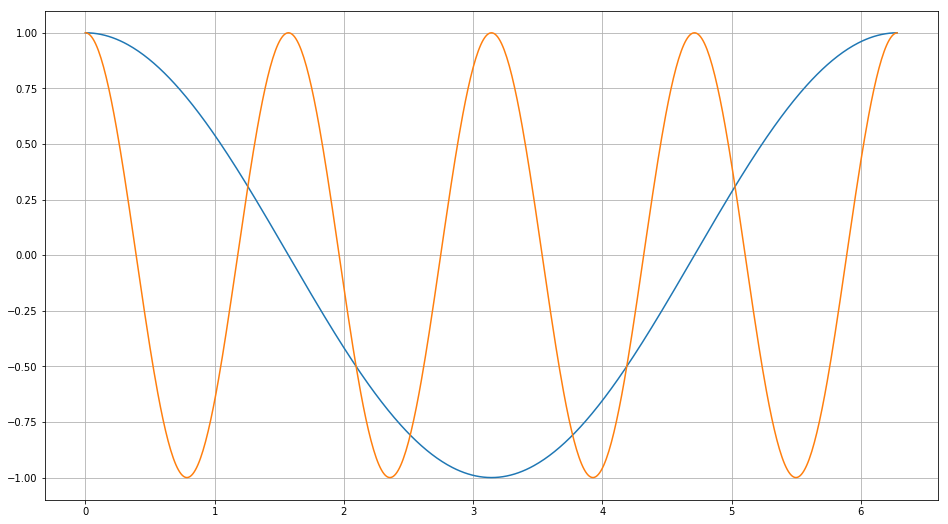

In [12]:
# Some tests to observe differents things (NOT SO IMPORTANT)
titi = np.arange(0,2*np.pi,0.01)

plt.figure(figsize=(16,9))
plt.plot(titi, np.cos(titi), titi,np.cos(4*titi))
plt.grid()
plt.show()

In [13]:
#A simple loop to observe the time needed to do a certain number of additions
counter = 0
for i in range(11529600):
    counter+=1
print(counter)

11529600
